# Agentic RAG and how to build them

Agentic RAG enhances traditional Retrieval Augmented Generation (RAG) by incorporating `AI agents that make decisions`, plan actions, and coordinate with tools or other agents to improve information retrieval and response generation. Instead of a fixed, predefined workflow, these agents dynamically determine the best approach for each task, including which sources to query and how to refine context. This leads to more accurate, nuanced, and adaptable responses, especially for complex, multi-step workflows

## Setup

In [ ]:
%pip install -r requirements.txt

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True) # Load environment variables from .env filex

True

In [2]:
import getpass
import os

if not os.getenv("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_TRACING"] = "true"
    os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
    os.environ["LANGSMITH_PROJECT"] = "Llama-RAG"
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass('Enter the your LangSmith API key: ')

## Components

### Chat Model

In [3]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
import getpass
import os

chat_model_type = "groq" # Change this to "ollama" if you want to use Ollama instead of Groq

if chat_model_type == "groq":
    if not os.environ.get("GROQ_API_KEY"):
        os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")
    llm = ChatGroq(
        model="llama-3.1-8b-instant",
        temperature=0
    )
elif chat_model_type == "ollama":
    llm = ChatOllama(
        model="llama3.2",
        temperature=0
    )

### Embedding Model

In [4]:
from langchain_openai import OpenAIEmbeddings
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## Agentic RAG

First, we will build a `retrieval agent` that has the ability to decide whether to retrieve the context from a vector repository or respond directly to the user, but with the difference that it will check the relevance of the documents after the retrieval step.

### Preprocess documents

In [5]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [8]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

### Create a retriever tool

In [9]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [10]:
from langchain.tools.retriever import create_retriever_tool

# retriever_tool = create_retriever_tool(
#     retriever,
#     "retrieve_blog_posts",
#     "Search and return information about Lilian Weng blog posts.",
#     response_format = "content_and_artifact"
# )

from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_blog_posts(query: str):
    """Search and return information about Lilian Weng blog posts."""
    retrieved_docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata['source']}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


In [11]:
retrieve_blog_posts.invoke({"query": "types of reward hacking"})

'Source: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/\nContent: Detecting Reward Hacking#\n\nSource: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/\nContent: Why does Reward Hacking Exist?#\n\nSource: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/\nContent: In-Context Reward Hacking#\n\nSource: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/\nContent: (Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.'

### Generate query

Let's define the `state` of the graph

In [47]:
from langgraph.graph import StateGraph
from langgraph.graph import MessagesState

class GraphState(MessagesState):
    """Custom state class for the workflow."""
    question: str

workflow = StateGraph(GraphState)

In [48]:
def generate_query_or_respond(state: GraphState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    user_message = state["messages"][-1]
    response = llm.bind_tools([retrieve_blog_posts]).invoke(state["messages"])
    return {"messages": [response], "question": user_message.content}

In [49]:
from langchain_core.messages import HumanMessage

# input = {"messages": [{"role": "user", "content": "hello!"}]}
input = {"messages": [HumanMessage(content="hello!")]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

It's nice to meet you. Is there something I can help you with today?


In [51]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages([
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ])
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (h8rvnswmy)
 Call ID: h8rvnswmy
  Args:
    query: types of reward hacking


### Grade documents

In [52]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


def grade_documents(state: GraphState) -> Literal["generate", "rewrite"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["question"]

    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    
    context = "\n\n".join(
        [msg.content for msg in reversed(recent_tool_messages)]
    )

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        llm.with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate"
    else:
        return "rewrite"

 With irrelevant documents in the tool response:

In [53]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    ),
    "question": "What does Lilian Weng say about types of reward hacking?"
}
grade_documents(input)

'rewrite'

And now with relevant documents:

In [54]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Source: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/\nContent: reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    ),
    "question": "What does Lilian Weng say about types of reward hacking?"
}
grade_documents(input)

'generate'

### Rewrite question

In [55]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning. Answer only with the improved question.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: GraphState):
    """Rewrite the original user question."""
    question = state["question"]
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [56]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    ),
    "question": "What does Lilian Weng say about types of reward hacking?"
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What are the specific types of reward hacking discussed by Lilian Weng, and how does she describe their implications for machine learning and artificial intelligence?


### Generate an answer

In [57]:
from langchain_core.messages import SystemMessage

SYSTEM_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Context: \n{context}"
)


def generate_answer(state: GraphState):
    """Generate an answer."""

    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]
    context = "\n\n".join(tool_message.content for tool_message in tool_messages)

    system_prompt = SYSTEM_PROMPT.format(context=context)
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_prompt)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]} # update the state with the response

In [58]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Source: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/\nContent: reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecification, and reward tampering.


### Assemble the graph

In [59]:
from langgraph.graph import START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retrieve_blog_posts]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
    {
        # If the documents are relevant, generate an answer
        "generate": "generate_answer",
        # If the documents are not relevant, rewrite the question
        "rewrite": "rewrite_question",
    },
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

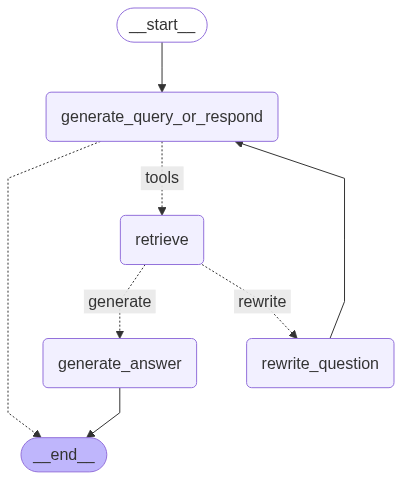

In [60]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Run the agentic RAG

In [61]:
config = {"configurable": {"thread_id": "111"}}

In [62]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    },
    config=config
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (kfw9jq6zn)
 Call ID: kfw9jq6zn
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Source: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/
Content: Detecting Reward Hacking#

Source: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/
Content: Why does Reward Hacking Exist?#

Source: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/
Content: In-Context Reward Hacking#

Source: https://lilianweng.github.io/posts/2024-11-28-reward-hacking/
Content: (Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into t

In [63]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What metrics are used to evaluate model hallucinations and what do they indicate?",
            }
        ]
    },
    config=config
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (f261ejyv3)
 Call ID: f261ejyv3
  Args:
    query: metrics for model hallucinations



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Source: https://lilianweng.github.io/posts/2024-07-07-hallucination/
Content: These empirical results from Gekhman et al. (2024) point out the risk of using supervised fine-tuning for updating LLMs’ knowledge.
Hallucination Detection#
Retrieval-Augmented Evaluation#

Source: https://lilianweng.github.io/posts/2024-07-07-hallucination/
Content: The evaluation framework for the FactualityPrompt benchmark.(Image source: Lee, et al. 2022)

Given the model continuation and paired Wikipedia text, two evaluation metrics for hallucination are considered:

Source: https://lilianweng.github.io/posts/2024-07-07-hallucination

In [64]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What was the last question I asked you?",
            }
        ]
    },
    config=config
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

Your last question was: What metrics are used to evaluate model hallucinations and what do they indicate?





## Adaptive RAG

Adaptive RAG is a strategy for RAG that unites (1) `query analysis` with (2) `active / self-corrective RAG`.

Instead of always using the same approach, Adaptive RAG analyzes the query and chooses the most appropriate strategy, be it simple retrieval, iterative retrieval, or no retrieval, seeking to balance accuracy and efficiency.

In our implementation, we will route between:

- Web search: for questions related to recent events
- Self-corrective RAG: for questions related to our index

In [5]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

Tavily is a search engine optimized for LLMs, aimed at efficient, quick and persistent search results.

Setup Tavily API Key:

In [6]:
_set_env("TAVILY_API_KEY")

### Create Index

In [7]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Router

In [8]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Who will the Bears draft first in the NFL draft?"}
    )
)

datasource='web_search'


In [9]:
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore'


### Retrieval Grader

In [ ]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

question = "agent memory"

docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Generate

In [11]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
docs_txt = format_docs(docs)
generation = rag_chain.invoke({"context": docs_txt, "question": question})
print(generation)

The agent memory in the context of LLM-powered autonomous agents is a long-term memory module that records a comprehensive list of agents' experiences in natural language, known as the "memory stream." This module is an external database that stores observations, events, and interactions between agents.


### Hallucination Grader

In [12]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

### Answer Grader

In [13]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### Question Rewriting

In [17]:
### Question Re-writer

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. Answer only with the improved question"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the definitions and characteristics of agent memory?'

### Web Search Tool

In [18]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

/tmp/ipykernel_16268/730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [ ]:
question = "Who will the Bears draft first in the NFL draft?"
docs = web_search_tool.invoke({"query": question})
docs

In [24]:
docs

[{'title': 'Grading all 8 picks of the Chicago Bears 2025 NFL Draft Class',
  'url': 'https://www.fox32chicago.com/sports/why-luther-burden-iii-got-a-grading-all-8-picks-chicago-bears-2025-nfl-draft-class',
  'content': "Two days before the draft, Colston Loveland was branding calves in Idaho. Now, he's the Bears' first-round pick. He goes one-on-one with FOX 32's Cassie Carlson.\n\nThe 2025 NFL Draft is in the books. How did the Bears do?\n\nHere's how we grade all eight of the Chicago Bears' selections in the 2025 NFL Draft.\n\n## Grading the Chicago Bears 2025 NFL Draft Class\n\n### No. 10 overall – Michigan TE Colston Loveland [...] There’s no denying how talented Monangai is. He’s had 21 touchdowns in the last two seasons of college football. In 669 career carries at Rutgers, he did not fumble the ball once. From the same program that gave the Kansas City Chiefs Isiah Pacheco, the Bears are hoping to tap into the pipeline.\n\nStill, in a draft that was deep with running backs and 

### Construct the Graph

In [49]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]
    count: int  

In [54]:
from pprint import pprint
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # set a count for the number of generations
    count = state.get("count", 0)
    if count == 5:
        print("---DECISION: TOO MANY NOT SUPPORTED GENERATIONS, Finalizing the flow---")
        return {"count": count}
    
    # RAG generation
    docs_txt = format_docs(documents)
    generation = rag_chain.invoke({"context": docs_txt, "question": question})
    count += 1
    return {"generation": generation, "count": count}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": [web_results], "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    count = state["count"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        if count == 5:
            return "useful"  # Finalize the flow if too many generations

        return "not supported"

### Compile Graph

In [55]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

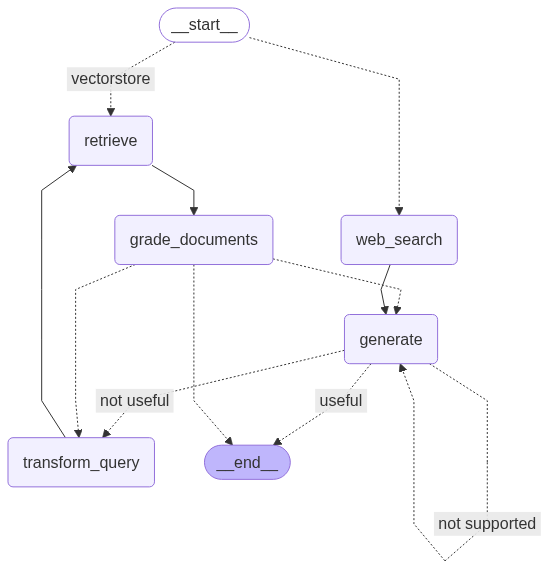

In [52]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

**Testing the graph**

In [46]:
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The Chicago Bears were expected to draft USC quarterback Caleb Williams with '
 'the first overall pick in the 2024 NFL draft. This expectation was '
 'solidified when the Bears traded quarterback Justin Fields to the Pittsburgh '
 'Steelers. Williams was ultimately chosen by the Bears with the first overall '
 'pick.')


In [47]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Based on the provided context, the types of agent memory are:\n'
 '\n'
 '1. Sensory Memory: equivalent to learning embedding representations for raw '
 'inputs.\n'
 '2. Short-term Memory: equivalent to in-context learning, short and finite.\n'
 '3. Long-term Memory: equivalent to an external vector store that the agent '
 'can attend to at query time, accessible via fast retrieval.')


In [57]:
# Run
inputs = {"question": "What is the purpose of presenting examples of few shots in a prompt?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The purpose of presenting few-shot examples in a prompt is to explain the '
 'intent to the model by describing the task instruction in the form of '
 'demonstrations, allowing the model to better understand human intention and '
 'criteria for desired answers. This approach often leads to better '
 'performance than zero-shot learning but comes at the cost of more token '
 'consumption. Few-shot examples help the model to be more aligned 

In [31]:
# Run
inputs = {"question": "agent memory"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The agent memory in the context of LLM-powered autonomous agents is a '
 "long-term memory module that records a comprehensive list of agents' "
 'experiences in natural language, known as the "memory stream." This module '
 'is an external database that stores observations, events, and interactions '
 'between agents.')


In [56]:
# Run
inputs = {"question": "prompt"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
"Node 'generate':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED 